# Temperature dependence of Hodgkin & Huxley action potentials

![image](https://www.gardeningknowhow.com/wp-content/uploads/2021/05/chili-pepper-400x300.jpg)

## Step 1: Setup

In [1]:
# Setup inline plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# For Google Colab, this line installs NEURON
!pip install neuron quantities

In [95]:
# We will let this library handle unit conversion for us
import quantities as pq
from quantities import um, nS, mV, cm, ms, nA, S, uF, Hz, degrees, s, MOhm

In [4]:
# Import and initialize NEURON
import neuron
from neuron import h
h.load_file("stdrun.hoc")

1.0

In [5]:
# Import other modules we need
import numpy as np

## Step 2: Define the circuit
We will use a single compartment, called a "Section" (more on that in next lectures). <br>
It has a cylindrical geometry with length "L" and a diameter "diam", and a specific capacitance "cm" (capacitance per area) <br>
**Unit conversion is a common source of error, so we will be explicit with our units.** 

In [6]:
soma = h.Section()

### Query NEURON for the expected units for soma.L & soma.diam

In [7]:
[h.units(x) for x in ["L", "diam"]]

['um', 'um']

In [8]:
soma.L = 10 * um
soma.diam =  10 * um

In [9]:
volume = soma(0.5).volume() * um**3

In [10]:
area = soma(0.5).area() * um**2

In [11]:
area

array(314.15926536) * um**2

In [12]:
volume

array(785.3981634) * um**3

### Assign the membrane capacitance "everywhere"

In [13]:
h.units("cm")  # Query the expected units

'uF/cm2'

In [14]:
specific_membrane_capacitance = 1 * uF/cm**2

In [15]:
for sec in soma.wholetree():
    sec.cm = specific_membrane_capacitance #  specific membrane capacitance (micro Farads / cm^2)
    sec.Ra = 100

### Add the Hodgkin-Huxley conductances

In [16]:
# This model includes the transient Na+, persistent K+ and the leak conductances
soma.insert("hh")

__nrnsec_0x1f42030

That's almost too easy!

### Parametize the leak conductance G = 1/R

In [17]:
G = 0.1 * nS  # R = 1/G in our RC circuit

In [18]:
v_rest = -70*mV

In [19]:
tau_m = soma(0.5).cm / soma(0.5).hh.gl

In [20]:
tau_m = (specific_membrane_capacitance * area / G).rescale(ms)

In [21]:
tau_m

array(31.41592654) * ms

In [22]:
# Assign the leak conductance everywhere
for seg in soma:
    seg.hh.gl = (G/area).rescale(S/cm**2)  # Compute specific conductance, and rescale to units of 'S/cm2'
    seg.hh.el = -54.3

### Inspect our parameters

In [23]:
soma.psection()

{'point_processes': {},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.036],
   'gl': [3.1830988618379074e-05],
   'el': [-54.3],
   'gna': [0.0],
   'gk': [0.0],
   'il': [0.0],
   'minf': [0.0],
   'hinf': [0.0],
   'ninf': [0.0],
   'mtau': [0.0],
   'htau': [0.0],
   'ntau': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 10.0,
  'diam': [10.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 100.0,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': '__nrnsec_0x1f42030',
 'hoc_internal_name': '__nrnsec_0x1f42030',
 'cell': None}

In [24]:
soma.nseg

1

### Add a current injection

In [25]:
stim = h.IClamp(soma(0.5))

In [49]:
stim.delay = 200 * ms  # Inject current 500ms after the start of the simulation 
stim.dur = 600 * ms  # stop injecting current at 520ms 
stim.amp = 0.013 * nA  # Inject 0.1 nA of current

## Step 3: Run the simulation

### Define recordings of simulation variables

In [27]:
soma_v = h.Vector().record(soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [28]:
# Record hh gating variables
hh_vars = ['h', 'm', 'n', 'gna', 'gk']
hh_recordings = {}
for var in hh_vars:
    ref = getattr(soma(0.5).hh, "_ref_"+var )
    hh_recordings[var] = h.Vector().record(ref) 

In [29]:
hh_recordings

{'h': Vector[2],
 'm': Vector[3],
 'n': Vector[4],
 'gna': Vector[5],
 'gk': Vector[6]}

In [87]:
temp_range = [3.6, 6.3, 9.8, 13.3, 20.2]
stim.amp = 0.02 * nA  # Inject 0.1 nA of current
stim.dur = 20 * ms

In [44]:
def run_sim(temp=6.3):
    h.celsius = temp
    h.finitialize( float(v_rest) )
    h.continuerun( float(1000 * ms) )
    return np.array(t), np.array(soma_v)

Text(0, 0.5, 'v (mV)')

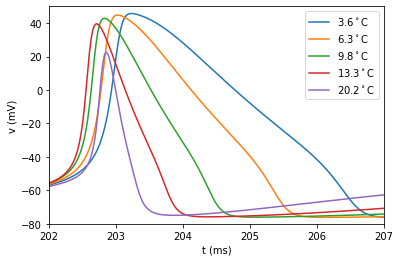

In [89]:
plt.figure()
for temp in temp_range:
    a_t, v = run_sim(temp)
    plt.plot(a_t, v, label='%.1f$^\circ$C' % temp)
plt.axis([202,207,-80,50])
#plt.axis([0.01, 0.02, 0, 100])
plt.legend()
plt.xlabel("t (ms)")
plt.ylabel("v (mV)")

## Now it's your turn!

### **Activity 1** - Investigate the HH Na+ ion currents with voltage clamp



In [112]:
# zero the current clamp to disable it
stim.amp = 0

### Add voltage clamp & define holding voltages

In [97]:
vclamp = h.SEClamp(soma(0.5))

In [111]:
vclamp.dur1 = 200 * ms  # vclamp of amp1 until dur1 after the start of the simulation 
vclamp.dur2 = 700 * ms  # start amp2 at dur1 and apply until dur1+dur2
vclamp.amp1 = v_rest #
vclamp.amp2 = -40*mV # holding voltage
vclamp.amp3 = v_rest # 

In [99]:
(1/G).rescale(MOhm) # What is Rin in MOhm?

array(10000.) * megaohm

In [100]:
vclamp.rs = 0.01 * MOhm # The clamp series resistance should be < 1/100 Rin

### Record the voltage clamp current

In [101]:
vclamp_i = h.Vector().record(vclamp._ref_i)

### Define a function to run simulations

In [114]:
def run_sim(holding_voltage, temp=6.3):
    h.celsis = temp
    
    # TODO
    
    pass

### Plot the current as a function of voltage step

### **Activity 2** - Investigate the temperature dependence of HH Na+ ion currents with voltage clamp




Plot the Na+ current using voltage clamp for a range of temperatures.  What is happening to the current as the temperature is lowered?

